# 

# Capstone Project - Women's Clothing Sentiment Analysis

# with Counter Vector and TF-IDF as Features (Part -1)

### Import libraries

In [1]:
## Import Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import string
import spacy
import regex as re
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

from collections import Counter

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

#### Load data

In [2]:
# Loading the data
df = pd.read_csv('./Data/Womens Clothing E-Commerce Reviews.csv')
df.head()


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## EDA

#### Inspect the data

- Check for
    - **Number of features**
    - **Data types**
    - **Domains, Intervals**
    - **Outliers** (are they valid or expurious data [read or measure errors])
  
    - **Missing Values** (coded [as zero of empty strings] or values not present)
    - **Coded content** (classes identified by numbers or codes to represent absence of data)


In [3]:
df.shape

(23486, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


###### Check for **Null** values 

In [5]:
df.isnull().sum()

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

###### Drop  null values and Drop Column Unnamed as it has no value in Analysis

In [6]:
df = df.dropna()

In [7]:
df=df.drop(['Unnamed: 0'], axis = 1)

In [8]:
df = df.reset_index(drop=True)

###### Check for **Zero** values 

In [9]:
df.isin([0]).sum()

Clothing ID                   0
Age                           0
Title                         0
Review Text                   0
Rating                        0
Recommended IND            3575
Positive Feedback Count    8930
Division Name                 0
Department Name               0
Class Name                    0
dtype: int64

In [10]:
# Both features can have zero values

<AxesSubplot:>

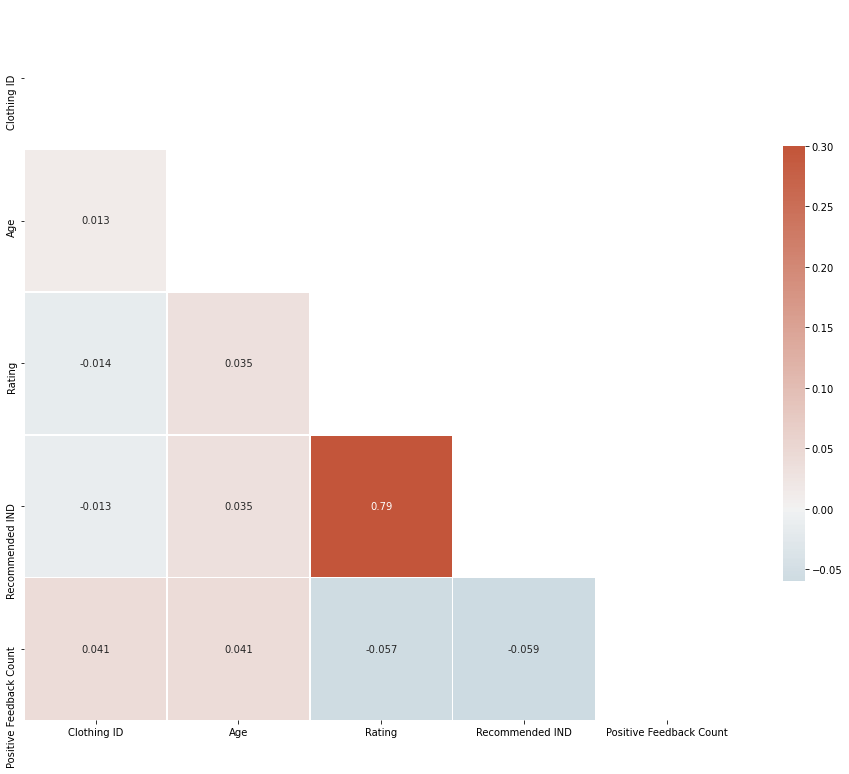

In [11]:
# correlation heatmap
plt.figure(figsize=(16, 16))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), annot=True, mask=mask, cmap=cmap,vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})             

In [12]:
# Select Data for Sentiment Analysis
df['Sentiment'] = df['Rating'].replace([1,2,3,4,5],[-1,-1,0,1,1])   
df1=df.drop(['Rating'], axis = 1)
df1 = df1.reset_index(drop=True)

In [13]:
df1.head()

,Clothing ID,Age,Title,Review Text,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Sentiment
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1,0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,1,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",0,4,General,Dresses,Dresses,-1
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,1,General Petite,Tops,Knits,1


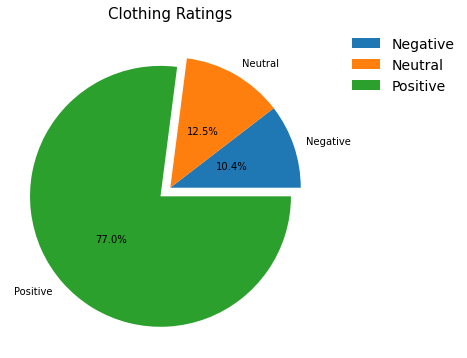

In [14]:
att=df1.groupby("Sentiment")['Sentiment'].count()
pie, ax = plt.subplots(figsize=[10,6])
labels = 'Negative','Neutral','Positive'
my_explode = (0, 0,0.1)
plt.pie(x=att, autopct="%.1f%%", explode=my_explode,labels=labels, pctdistance=0.5)
plt.title("Clothing Ratings", fontsize=15);
ax.legend(frameon=False, bbox_to_anchor=(1.02, 1),fontsize=14)

In [15]:
# Baseline accuracy is 77%

###### Data Cleaning for Analysis

###### Step 1 - Clean text

In [16]:
def clean_text(text):

    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)

    # remove double quotes
    text = re.sub(r'"', '', text)
    # remove special characters, numbers, punctuations
    text = re.sub(r'[^a-zA-Z#]', ' ', text)
    # remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ' , text)
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)

    return text

In [17]:
# Clean Data
df1['Review Text'] = df1['Review Text'].apply(clean_text)
df1['Title'] = df1['Title'].apply(clean_text)

In [18]:
df1[['Review Text','Title']].head(10)

,Review Text,Title
0,I had such high hopes for this dress and reall...,Some major design flaws
1,I love love love this jumpsuit it fun fli...,My favorite buy
2,This shirt is very flattering to all due to th...,Flattering shirt
3,I love tracy reese dresses but this one is no...,Not for the very petite
4,I aded this in my basket at hte last mintue to...,Cagrcoal shimmer fun
5,I ordered this in carbon for store pick up an...,Shimmer surprisingly goes with lots
6,I love this dress usually get an xs but it run...,Flattering
7,I and lbs ordered the petite to make sure ...,Such fun dress
8,Dress runs small esp where the zipper area run...,Dress looks like it made of cheap material
9,More and more find myself reliant on the revie...,Perfect


###### Step 2 - Remove stop words, puctuations and  perform lemmatization

In [19]:
nlp = spacy.load('en_core_web_sm')

In [20]:
# remove stop words, puctuations and  perform lemmatization
def convert_text(text):
    '''
    Use techniques learned in previous labs. Remove StopWords, Punctuation, Lemmatize etc.
    '''
    doc = nlp(text)
    t = [w for w in doc if not (w.is_stop | w.is_punct)]
    x = [w.lemma_.lower() for w in t]

    s= " ".join(x)

    return s

In [21]:
%%time
df1['Review Text'] = df1['Review Text'].apply(convert_text)
df1['Title'] = df1['Title'].apply(convert_text)

Wall time: 4min 6s


In [22]:
df1[['Review Text','Title']].head(5)

,Review Text,Title
0,high hope dress want work initially order peti...,major design flaw
1,love love love jumpsuit fun flirty ...,favorite buy
2,shirt flattering adjustable tie perfect leng...,flattering shirt
3,love tracy reese dress petite foot tall u...,petite
4,ade basket hte mintue look like person stor...,cagrcoal shimmer fun


#### Balance Dataset

In [23]:
# Features and Labels
X =df1['Review Text']
y = y = df1['Sentiment']

## Split the data into train and test

In [24]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Feature Engineering

### Count Vectors as features

In [25]:
# create a count vectorizer object
count_vect = CountVectorizer(token_pattern = r'\w{1,}')

# Learn a vocabulary dictionary of all tokens in the raw documents
count_vect.fit(df1['Review Text'])

# Transform documents to document-term matrix.
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

In [26]:
# import library
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
X_train_count, y_smote = smote.fit_resample(X_train_count, y_train)
X_test_count, y_smote_test = smote.fit_resample(X_test_count, y_test)

In [27]:
X_train_count.shape

(36210, 10276)

In [28]:
X_train_count

<36210x10276 sparse matrix of type '<class 'numpy.int64'>'
	with 900048 stored elements in Compressed Sparse Row format>

### TF-IDF Vectors as features
- Word level
- N-Gram level
- Character level

In [29]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 500)
print(tfidf_vect)

tfidf_vect.fit(df1['Review Text'])
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

# fit predictor and target variable
X_train_tfidf, y_smote = smote.fit_resample(X_train_tfidf, y_train)
X_test_tfidf , y_smote_test = smote.fit_resample(X_test_tfidf , y_test)

TfidfVectorizer(max_features=500, token_pattern='\\w{1,}')
Wall time: 954 ms


In [30]:
%%time
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3),
                                   max_features = 500)
print(tfidf_vect_ngram)

tfidf_vect_ngram.fit(df1['Review Text'])
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test)

# fit predictor and target variable
X_train_tfidf_ngram, y_smote = smote.fit_resample(X_train_tfidf_ngram, y_train)
X_test_tfidf_ngram , y_smote_test = smote.fit_resample(X_test_tfidf_ngram , y_test)

TfidfVectorizer(max_features=500, ngram_range=(2, 3), token_pattern='\\w{1,}')
Wall time: 3.46 s


In [31]:
%%time
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer = 'char',
                                         token_pattern = r'\w{1,}',
                                         ngram_range = (2, 3),
                                         max_features = 500)
print(tfidf_vect_ngram_chars)

tfidf_vect_ngram_chars.fit(df1['Review Text'])
X_train_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_train)
X_test_tfidf_ngram_chars  = tfidf_vect_ngram_chars.transform(X_test)

# fit predictor and target variable
X_train_tfidf_ngram_chars, y_smote = smote.fit_resample(X_train_tfidf_ngram_chars, y_train)
X_test_tfidf_ngram_chars , y_smote_test = smote.fit_resample(X_test_tfidf_ngram_chars , y_test)

TfidfVectorizer(analyzer='char', max_features=500, ngram_range=(2, 3),
                token_pattern='\\w{1,}')


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:506: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


Wall time: 6.98 s


## Modelling

In [32]:
import time

In [33]:
# Model evaluation function
def evaluate_model(classifier, feature_vector_train, label_train, feature_vector_test,label_test):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label_train)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    # predict accuracy
    print(f" Accuracy Score for train data = {classifier.score(feature_vector_train, label_train)}")
    print(f" Accuracy Score for test data = {classifier.score(feature_vector_test, label_test)}")
    
    
    # confusion matrix
    log_cm = metrics.confusion_matrix(label_test, predictions,[-1,0,1])
    sns.heatmap(log_cm, annot=True, fmt='.2f',xticklabels = ["Negative","Neutral", "Positive"] , yticklabels = ["Negative","Neutral", "Positive"],cmap='Blues' )
    plt.title('Confusion Matrics')
    plt.savefig('cm')
    
   
    # Classification Report for test data
    print("Classification Report for test data")
    print(classification_report(label_test, predictions))
    
    return classifier.score(feature_vector_test, label_test)


In [34]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Count Vectors',
                                  'WordLevel TF-IDF',
                                  'N-Gram Vectors',
                                  'CharLevel Vectors'])

### Naive Bayes Classifier

#### Count Vectors

 Accuracy Score for train data = 0.7450151891742612
 Accuracy Score for test data = 0.6157512728848445
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.55      0.55      0.55      3077
           0       0.47      0.43      0.45      3077
           1       0.79      0.86      0.83      3077

    accuracy                           0.62      9231
   macro avg       0.61      0.62      0.61      9231
weighted avg       0.61      0.62      0.61      9231



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 201 ms


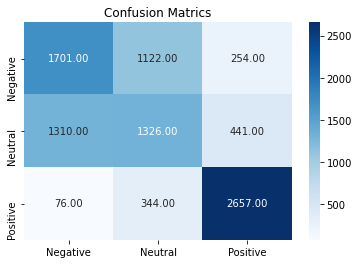

In [35]:
%%time
# Naive Bayes on Count Vectors
accuracy1 = evaluate_model(MultinomialNB(), X_train_count, y_smote,X_test_count , y_smote_test)

#### On Word Level TF IDF Vectors

 Accuracy Score for train data = 0.6868544600938967
 Accuracy Score for test data = 0.6379590510237244


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Classification Report for test data
              precision    recall  f1-score   support

          -1       0.64      0.55      0.59      3077
           0       0.52      0.59      0.55      3077
           1       0.77      0.77      0.77      3077

    accuracy                           0.64      9231
   macro avg       0.64      0.64      0.64      9231
weighted avg       0.64      0.64      0.64      9231

Wall time: 209 ms


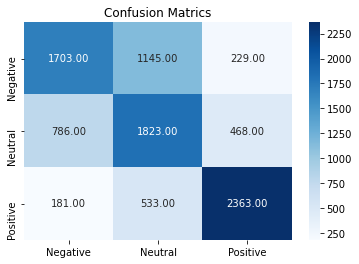

In [36]:
%%time
# Naive Bayes on word Level TF IDF Vectors
accuracy2 = evaluate_model(MultinomialNB(), X_train_tfidf, y_smote,X_test_tfidf  , y_smote_test)

#### on Ngram Level TF IDF Vectors

 Accuracy Score for train data = 0.5902236951118476
 Accuracy Score for test data = 0.524753547827971


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Classification Report for test data
              precision    recall  f1-score   support

          -1       0.50      0.58      0.54      3077
           0       0.45      0.36      0.40      3077
           1       0.60      0.63      0.62      3077

    accuracy                           0.52      9231
   macro avg       0.52      0.52      0.52      9231
weighted avg       0.52      0.52      0.52      9231

Wall time: 192 ms


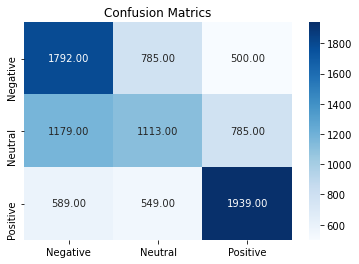

In [37]:
%%time
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy3 = evaluate_model(MultinomialNB(), X_train_tfidf_ngram, y_smote,X_test_tfidf_ngram  , y_smote_test)

#### on CharacterLevel TF IDF Vectors

 Accuracy Score for train data = 0.5908864954432477
 Accuracy Score for test data = 0.5588776947242986


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Classification Report for test data
              precision    recall  f1-score   support

          -1       0.53      0.57      0.55      3077
           0       0.45      0.44      0.45      3077
           1       0.70      0.66      0.68      3077

    accuracy                           0.56      9231
   macro avg       0.56      0.56      0.56      9231
weighted avg       0.56      0.56      0.56      9231

Wall time: 265 ms


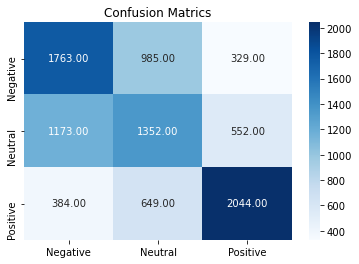

In [38]:
%%time
# Naive Bayes on Character Level TF IDF Vectors
accuracy4 = evaluate_model(MultinomialNB(), X_train_tfidf_ngram_chars, y_smote,X_test_tfidf_ngram_chars  , y_smote_test)

In [39]:
results.loc['Naïve Bayes'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [40]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
Naïve Bayes,0.615751,0.637959,0.524754,0.558878


### Linear Classifier

#### Count Vectors

C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


 Accuracy Score for train data = 0.7982601491300746
 Accuracy Score for test data = 0.6421839454013649
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.54      0.62      0.58      3077
           0       0.50      0.45      0.47      3077
           1       0.91      0.86      0.88      3077

    accuracy                           0.64      9231
   macro avg       0.65      0.64      0.64      9231
weighted avg       0.65      0.64      0.64      9231

Wall time: 2.06 s


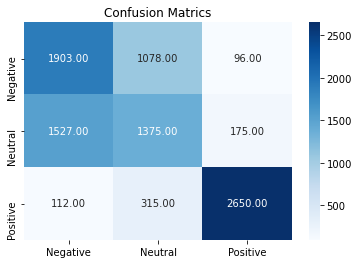

In [41]:
%%time
# Logistic Regression on Count Vectors
accuracy1 = evaluate_model(LogisticRegression(), X_train_count, y_smote,X_test_count , y_smote_test)

#### On Word Level TF IDF Vectors

 Accuracy Score for train data = 0.7255730461198564
 Accuracy Score for test data = 0.635900769147438
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.60      0.61      0.61      3077
           0       0.52      0.49      0.51      3077
           1       0.77      0.81      0.79      3077

    accuracy                           0.64      9231
   macro avg       0.63      0.64      0.63      9231
weighted avg       0.63      0.64      0.63      9231

Wall time: 540 ms


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


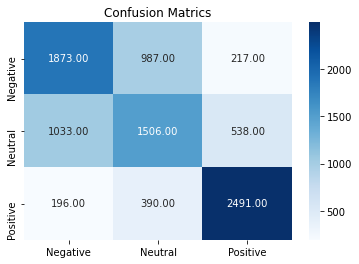

In [42]:
%%time
# Logistic Regression on TF IDF
accuracy2 = evaluate_model(LogisticRegression(solver='liblinear'),  X_train_tfidf, y_smote,X_test_tfidf , y_smote_test)

#### on Ngram Level TF IDF Vectors

 Accuracy Score for train data = 0.6234741784037559
 Accuracy Score for test data = 0.550211244718882
Classification Report for test data


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


              precision    recall  f1-score   support

          -1       0.49      0.63      0.55      3077
           0       0.45      0.33      0.38      3077
           1       0.71      0.69      0.70      3077

    accuracy                           0.55      9231
   macro avg       0.55      0.55      0.54      9231
weighted avg       0.55      0.55      0.54      9231

Wall time: 358 ms


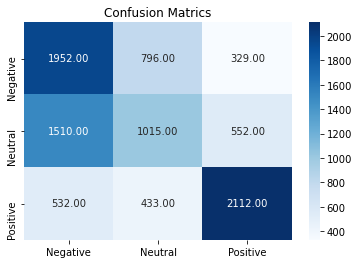

In [43]:
%%time
# Logistic Regression on Ngram Level
accuracy3 = evaluate_model(LogisticRegression(solver='liblinear'),  X_train_tfidf_ngram, y_smote,X_test_tfidf_ngram , y_smote_test)

#### on Character Level Level TF IDF Vectors

 Accuracy Score for train data = 0.6887876277271472
 Accuracy Score for test data = 0.6132596685082873
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.59      0.60      0.59      3077
           0       0.51      0.46      0.48      3077
           1       0.73      0.78      0.75      3077

    accuracy                           0.61      9231
   macro avg       0.61      0.61      0.61      9231
weighted avg       0.61      0.61      0.61      9231



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 3.51 s


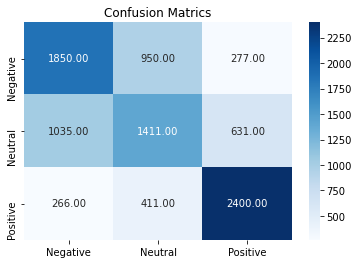

In [44]:
%%time
# Logistic Regression on Character Level 
accuracy4 = evaluate_model(LogisticRegression(solver='liblinear'),  X_train_tfidf_ngram_chars, y_smote,X_test_tfidf_ngram_chars  , y_smote_test)

In [45]:
results.loc['Logistic Regression'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

### Bagging Models

#### Count Vectors

 Accuracy Score for train data = 0.9663904998619166
 Accuracy Score for test data = 0.6427255985267035
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.55      0.53      0.54      3077
           0       0.52      0.48      0.50      3077
           1       0.81      0.92      0.87      3077

    accuracy                           0.64      9231
   macro avg       0.63      0.64      0.63      9231
weighted avg       0.63      0.64      0.63      9231



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 1min 33s


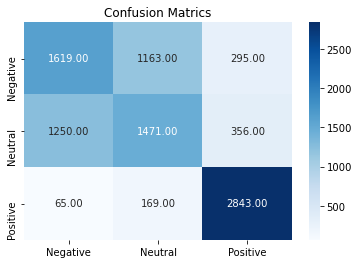

In [46]:
%%time
# Bagging (Random Forest) on Count Vectors
accuracy1 = evaluate_model(RandomForestClassifier(), X_train_count, y_smote, X_test_count,y_smote_test)

#### On Word Level TF IDF Vectors

 Accuracy Score for train data = 1.0
 Accuracy Score for test data = 0.6534503304084065


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Classification Report for test data
              precision    recall  f1-score   support

          -1       0.64      0.50      0.56      3077
           0       0.57      0.52      0.55      3077
           1       0.72      0.94      0.81      3077

    accuracy                           0.65      9231
   macro avg       0.64      0.65      0.64      9231
weighted avg       0.64      0.65      0.64      9231

Wall time: 57.6 s


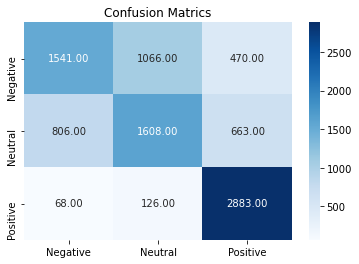

In [47]:
%%time
# Bagging (Random Forest) on Word Level TF IDF Vectors
accuracy2 = evaluate_model(RandomForestClassifier(), X_train_tfidf, y_smote, X_test_tfidf,y_smote_test)

#### Bagging (Random Forest) on Ngram Level TF IDF Vectors

 Accuracy Score for train data = 0.9106324219828776
 Accuracy Score for test data = 0.5368865778355542
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.47      0.49      0.48      3077
           0       0.48      0.35      0.41      3077
           1       0.63      0.76      0.69      3077

    accuracy                           0.54      9231
   macro avg       0.53      0.54      0.53      9231
weighted avg       0.53      0.54      0.53      9231



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 30.8 s


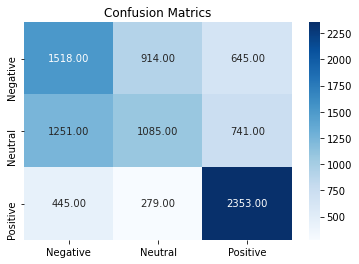

In [48]:
%%time
# Bagging (Random Forest) on Ngram Level TF IDF Vectors
accuracy3 = evaluate_model(RandomForestClassifier(), X_train_tfidf_ngram, y_smote, X_test_tfidf_ngram,y_smote_test)

#### Bagging (Random Forest) on  on Character Level TF IDF Vectors

 Accuracy Score for train data = 1.0
 Accuracy Score for test data = 0.6385007041490629
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.61      0.46      0.52      3077
           0       0.55      0.51      0.53      3077
           1       0.72      0.95      0.82      3077

    accuracy                           0.64      9231
   macro avg       0.63      0.64      0.62      9231
weighted avg       0.63      0.64      0.62      9231



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 3min 3s


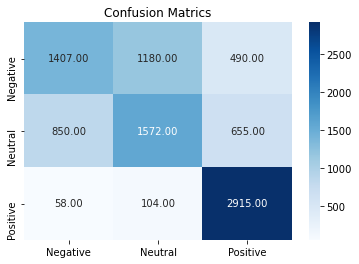

In [49]:
%%time
# Bagging (Random Forest) on  on Character Level TF IDF Vectors
accuracy4 = evaluate_model(RandomForestClassifier(), X_train_tfidf_ngram_chars, y_smote, X_test_tfidf_ngram_chars,y_smote_test)

In [50]:
results.loc['Random Forest'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

### Boosting Models

 Accuracy Score for train data = 0.7047224523612262
 Accuracy Score for test data = 0.6385007041490629
Classification Report for test data


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


              precision    recall  f1-score   support

          -1       0.54      0.65      0.59      3077
           0       0.51      0.42      0.46      3077
           1       0.86      0.84      0.85      3077

    accuracy                           0.64      9231
   macro avg       0.64      0.64      0.64      9231
weighted avg       0.64      0.64      0.64      9231

Wall time: 42.5 s


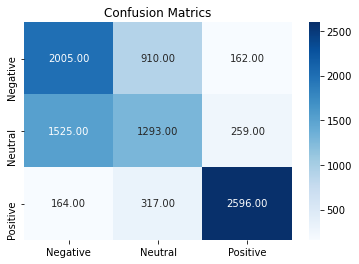

In [51]:
%%time
# Gradient Boosting on Count Vectors
accuracy1 = evaluate_model(GradientBoostingClassifier(n_estimators=100), X_train_count, y_smote, X_test_count,y_smote_test)

###### Gradient Boosting on Word Level TF IDF Vectors

 Accuracy Score for train data = 0.7844518088925712
 Accuracy Score for test data = 0.6718665366699166


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Classification Report for test data
              precision    recall  f1-score   support

          -1       0.62      0.57      0.59      3077
           0       0.59      0.54      0.57      3077
           1       0.78      0.90      0.84      3077

    accuracy                           0.67      9231
   macro avg       0.66      0.67      0.67      9231
weighted avg       0.66      0.67      0.67      9231

GB, WordLevel TF-IDF : 0.6719

Wall time: 1min 14s


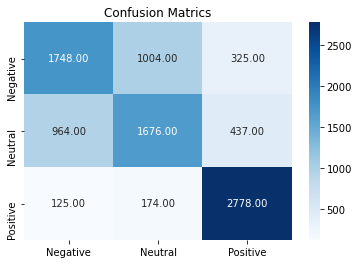

In [52]:
%%time
# Gradient Boosting on Word Level TF IDF Vectors
accuracy2 = evaluate_model(GradientBoostingClassifier(), X_train_tfidf, y_smote, X_test_tfidf,y_smote_test)
print('GB, WordLevel TF-IDF : %.4f\n' % accuracy2)

###### Gradient Boosting on Ngram Level TF IDF Vectors

 Accuracy Score for train data = 0.5943661971830986
 Accuracy Score for test data = 0.4994041815621276


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Classification Report for test data
              precision    recall  f1-score   support

          -1       0.47      0.27      0.34      3077
           0       0.40      0.68      0.50      3077
           1       0.75      0.55      0.64      3077

    accuracy                           0.50      9231
   macro avg       0.54      0.50      0.49      9231
weighted avg       0.54      0.50      0.49      9231

GB, N-Gram Vectors   : 0.4994

Wall time: 11.1 s


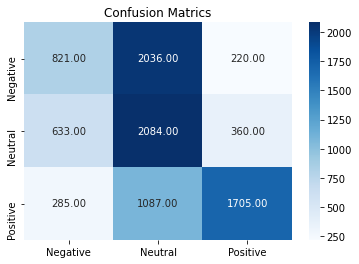

In [53]:
%%time
# Gradient Boosting on Ngram Level TF IDF Vectors
accuracy3 = evaluate_model(GradientBoostingClassifier(), X_train_tfidf_ngram, y_smote, X_test_tfidf_ngram,y_smote_test)
print('GB, N-Gram Vectors   : %.4f\n' % accuracy3)

###### Gradient Boosting on Character Level TF IDF Vectors

 Accuracy Score for train data = 0.8186412593206297
 Accuracy Score for test data = 0.6629834254143646


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Classification Report for test data
              precision    recall  f1-score   support

          -1       0.58      0.54      0.56      3077
           0       0.57      0.50      0.53      3077
           1       0.80      0.95      0.87      3077

    accuracy                           0.66      9231
   macro avg       0.65      0.66      0.65      9231
weighted avg       0.65      0.66      0.65      9231

GB, CharLevel Vectors: 0.6630

Wall time: 11min 21s


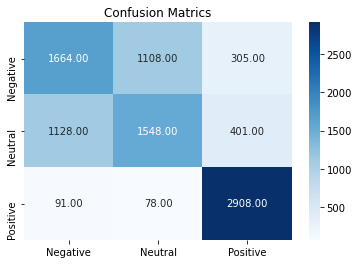

In [54]:
%%time
# Gradient Boosting on Character Level TF IDF Vectors
accuracy4 = evaluate_model(GradientBoostingClassifier(), X_train_tfidf_ngram_chars, y_smote, X_test_tfidf_ngram_chars,y_smote_test)
print('GB, CharLevel Vectors: %.4f\n' % accuracy4)

In [55]:
results.loc['Gradient Boosting'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [56]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
Naïve Bayes,0.615751,0.637959,0.524754,0.558878
Logistic Regression,0.642184,0.635901,0.550211,0.613260
Random Forest,0.642726,0.653450,0.536887,0.638501
Gradient Boosting,0.638501,0.671867,0.499404,0.662983
